In [2]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import neighbors, datasets, preprocessing
from sklearn.model_selection import train_test_split
from scipy.stats import chi2_contingency

%matplotlib inline

In [3]:
moCoDetails = pd.read_csv("moCoDetails.csv")

/Users/maryglantz/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (3,47) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [13]:
moCoDetails.columns

Index(['Unnamed: 0', 'Unnamed: 0_x', 'report_number', 'local_case_number_x',
       'agency_name_x', 'acrs_report_type_x', 'crash_date_time_x', 'hit_run',
       'route_type_x', 'mile_point',
       ...
       'pedestrian_actions', 'pedestrian_location',
       'pedestrian_obeyed_traffic_signal', 'pedestrian_visibility',
       'at_fault_y', 'injury_severity_y', 'safety_equipment', 'latitude',
       'longitude', 'location'],
      dtype='object', length=121)


In [5]:
pd.crosstab(moCoDetails.injury_severity_y, moCoDetails.speed_limit)

speed_limit,0.0,5.0,10.0,15.0,20.0,25.0,30.0,35.0,40.0,45.0,50.0,55.0
injury_severity_y,,,,,,,,,,,,
FATAL INJURY,1,0,0,1,0,8,13,21,32,11,4,0
NO APPARENT INJURY,19,27,12,39,3,118,44,77,26,9,1,3
POSSIBLE INJURY,86,97,67,126,16,321,175,272,95,56,10,2
SUSPECTED MINOR INJURY,91,101,73,165,18,423,259,355,174,65,16,2
SUSPECTED SERIOUS INJURY,15,13,10,23,4,89,59,114,70,30,11,3


In [6]:
# Null hypothesis is that speed limit has no relationship to severity of injuries

chi2_contingency(pd.crosstab(moCoDetails.injury_severity_y, moCoDetails.speed_limit))

(225.55582540774543,
 3.147517767425494e-26,
 44,
 array([[4.85333333e+00, 5.44855346e+00, 3.70867925e+00, 8.10415094e+00,
         9.38616352e-01, 2.19544654e+01, 1.25911950e+01, 1.92072956e+01,
         9.08855346e+00, 3.91471698e+00, 9.61509434e-01, 2.28930818e-01],
        [2.01600000e+01, 2.26324528e+01, 1.54052830e+01, 3.36633962e+01,
         3.89886792e+00, 9.11954717e+01, 5.23018868e+01, 7.97841509e+01,
         3.77524528e+01, 1.62611321e+01, 3.99396226e+00, 9.50943396e-01],
        [7.05600000e+01, 7.92135849e+01, 5.39184906e+01, 1.17821887e+02,
         1.36460377e+01, 3.19184151e+02, 1.83056604e+02, 2.79244528e+02,
         1.32133585e+02, 5.69139623e+01, 1.39788679e+01, 3.32830189e+00],
        [9.29066667e+01, 1.04300881e+02, 7.09947170e+01, 1.55136604e+02,
         1.79677987e+01, 4.20271195e+02, 2.41031447e+02, 3.67682516e+02,
         1.73980881e+02, 7.49388679e+01, 1.84060377e+01, 4.38238994e+00],
        [2.35200000e+01, 2.64045283e+01, 1.79728302e+01, 3.92739623e+0

The p-score is 3.1475e-26, which is very low, and indicates we can reject the null hypothesis.  In other words, the speed limit has a relationship to the severity of the injury.

In [7]:
pd.crosstab(moCoDetails.injury_severity_y, moCoDetails.number_of_lanes)

number_of_lanes,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0
injury_severity_y,,,,,,,,
FATAL INJURY,4,7,25,40,4,5,7,0
NO APPARENT INJURY,98,116,105,53,16,0,3,0
POSSIBLE INJURY,353,319,346,258,41,10,18,0
SUSPECTED MINOR INJURY,409,414,533,302,78,20,21,1
SUSPECTED SERIOUS INJURY,62,78,131,127,32,9,8,0


In [8]:
# There are no zero lane roads, so we will drop that for our analysis

zeroLanes = moCoDetails['number_of_lanes'] != 0.0
laneNumbers = moCoDetails[zeroLanes]
pd.crosstab(laneNumbers.injury_severity_y, laneNumbers.number_of_lanes)

number_of_lanes,1.0,2.0,3.0,4.0,5.0,6.0,7.0
injury_severity_y,,,,,,,
FATAL INJURY,7,25,40,4,5,7,0
NO APPARENT INJURY,116,105,53,16,0,3,0
POSSIBLE INJURY,319,346,258,41,10,18,0
SUSPECTED MINOR INJURY,414,533,302,78,20,21,1
SUSPECTED SERIOUS INJURY,78,131,127,32,9,8,0


In [9]:
# Null hypothesis is that number of lanes has no relationship to severity of injuries

chi2_contingency(pd.crosstab(laneNumbers.injury_severity_y, laneNumbers.number_of_lanes))

(127.17610210917115,
 5.02196058266101e-16,
 24,
 array([[2.62846178e+01, 3.20818676e+01, 2.19507515e+01, 4.81228014e+00,
         1.23824752e+00, 1.60409338e+00, 2.81419891e-02],
        [8.75158299e+01, 1.06818036e+02, 7.30860249e+01, 1.60227055e+01,
         4.12280141e+00, 5.34090182e+00, 9.37000320e-02],
        [2.96299328e+02, 3.61650144e+02, 2.47444835e+02, 5.42475216e+01,
         1.39584266e+01, 1.80825072e+01, 3.17236968e-01],
        [4.08905021e+02, 4.99091781e+02, 3.41483850e+02, 7.48637672e+01,
         1.92631916e+01, 2.49545891e+01, 4.37799808e-01],
        [1.14995203e+02, 1.40358171e+02, 9.60345379e+01, 2.10537256e+01,
         5.41733291e+00, 7.01790854e+00, 1.23121202e-01]]))

This too has a very low p-number, so the number of lanes probably has a relationship with the severity of injuries.  (It probably has a relationship with the speed limit as well.). We can do a chi-squared test on that too to see.


In [10]:
# Null hypothesis is that number of lanes has no relationship to speed limit

chi2_contingency(pd.crosstab(laneNumbers.speed_limit, laneNumbers.number_of_lanes))

(26370.765167728292,
 0.0,
 168,
 array([[9.81526797e+01, 1.64642469e+02, 1.76135939e+02, 4.39268461e+01,
         9.20024654e+00, 9.15009653e+00, 1.12153650e+00, 5.15177333e-01,
         6.83863717e-02, 4.10318230e-02, 9.11818289e-03, 1.82363658e-02,
         1.82363658e-02],
        [5.99063075e+01, 1.00487551e+02, 1.07502452e+02, 2.68102222e+01,
         5.61525981e+00, 5.58465136e+00, 6.84516310e-01, 3.14432289e-01,
         4.17387994e-02, 2.50432796e-02, 5.56517325e-03, 1.11303465e-02,
         1.11303465e-02],
        [7.68830135e+01, 1.28964479e+02, 1.37967316e+02, 3.44079073e+01,
         7.20655494e+00, 7.16727243e+00, 8.78499760e-01, 4.03538508e-01,
         5.35670585e-02, 3.21402351e-02, 7.14227447e-03, 1.42845489e-02,
         1.42845489e-02],
        [2.60699762e+02, 4.37300873e+02, 4.67828259e+02, 1.16672498e+02,
         2.44364401e+01, 2.43032385e+01, 2.97887228e+00, 1.36834377e+00,
         1.81638554e-01, 1.08983132e-01, 2.42184738e-02, 4.84369477e-02,
         4.84

This has a p-score of zero, so it is very probable there is a relationship between speed limit and number of lanes. 

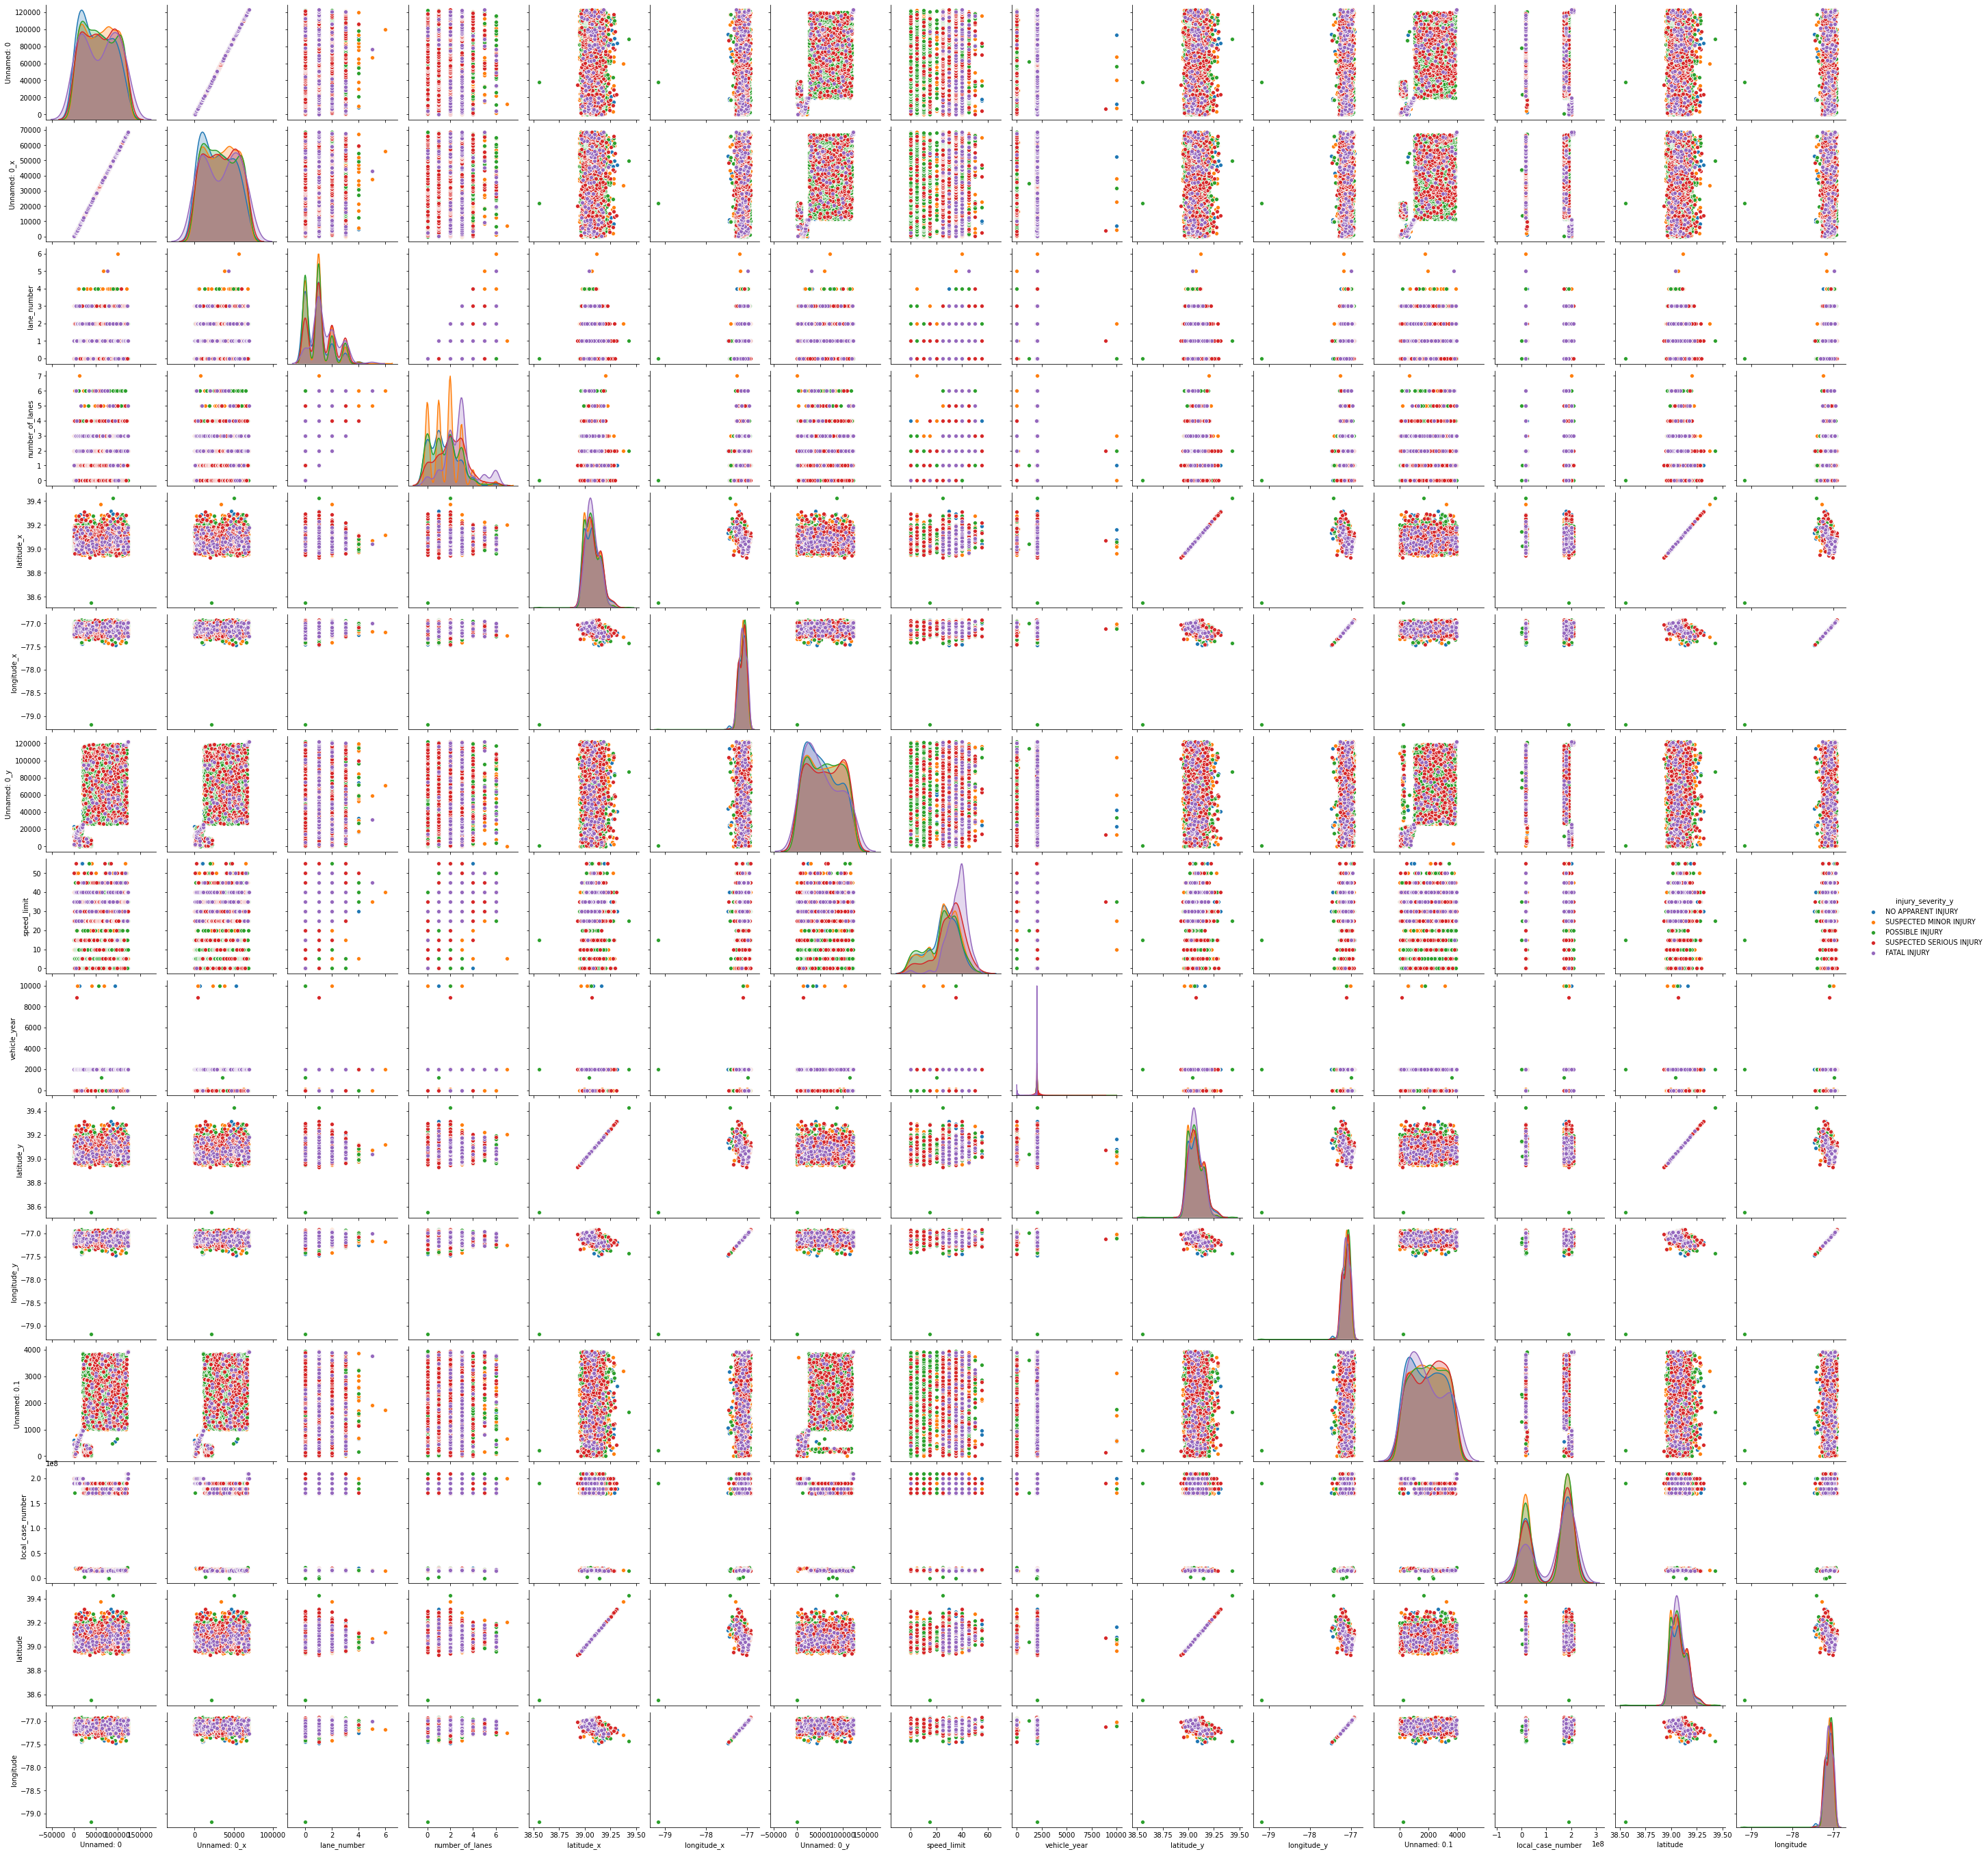

In [12]:
sns.pairplot(moCoDetails, hue = "injury_severity_y", height = 2.5)